# Multi-time correlations

In this tutorial, we show how to use the OQuPy package to calculate multi-time correlations functions for non-Markovian open quantum systems. We will calculate a series of four-time correlation functions to simulate a 2D electronic spectoscopy measurement.

- [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fn_time_correlations.ipynb) (runs in browser)
- [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/n_time_correlations.ipynb)
- or read through the text below and code along.


**Contents:**

* Background - 2D electronic spectroscopy
* Example - A three-level chromophore
    * 1. Computing the process tensor
    * 2. Define the system and dipole operators
    * 3. Calculate four-time correlation functions
    * 4. Plot a 2D spectrum

To start, we import OQuPy and some packages we need to Fourier transform  and plot the results:

In [1]:
import sys
sys.path.insert(0,'..')

import oqupy
from oqupy.contractions import compute_nt_correlations
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift, fft2

Additionally, we define some matrices required to describe our example system:

In [2]:
P_1 = np.array([[0., 0., 0.],
       [0., 1., 0.],[0., 0., 0.]], dtype=complex)

P_2 = np.array([[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],[0.+0.j, 0.+0.j, 1.+0.j]],dtype=complex)

sigma_min = np.array([[0., 0., 0.],
       [0., 0., 1.],[0., 0., 0.]],dtype=complex)

sigma_plus = np.array([[0., 0., 0.],
       [0., 0., 0.],[0., 1., 0.]],dtype=complex)

dip_02 = np.array([[0., 0., 1.],
       [0., 0., 0.],[1., 0., 0.]],dtype=complex)

## Background - 2D electronic spectroscopy
To illustrate how multi-time correlation functions are calculated with OQuPy, we'll reconstruct Figure 2(a) of [deWit2024] ([arXiv:2402.15454](https://arxiv.org/abs/2402.15454)). This figure depicts a simulated 2D spectrum for a three-level system that captures the essential features of a chromophore (i.e. light absorbing molecule). 

2D electronic spectroscopy (2DES) is an experimental technique that probes a system with three femtosecond laser pulses. Due to its sensitivity to the complex phases of the system, the resulting signal can capture how energy excitations evolve and decohere in real time. Mathematically, a 2DES signal is expressed as a third-order response function, consisting of a series of four-time correlation functions. Here, we will consider a signal made up of four correlation functions, given by:
$$ 
\begin{align}
R_1 &=  \mathrm{Tr}\big[ \hat{V}(\tau_4)\hat{V}(\tau_1)\rho_0\hat{V}(\tau_2)\hat{V}(\tau_3) \big] \\
R_2 &= \mathrm{Tr} \big[\hat{V}(\tau_4)\hat{V}(\tau_2)\rho_0 \hat{V}(\tau_1)\hat{V}(\tau_3) \big] \\
R_3 &= \mathrm{Tr} \big[\hat{V}(\tau_4)\hat{V}(\tau_3)\rho_0 \hat{V}(\tau_1)\hat{V}(\tau_2) \big] \\
R_4 &= \mathrm{Tr} \big[\hat{V}(\tau_4)\hat{V}(\tau_3)\hat{V}(\tau_2)\hat{V}(\tau_1) \rho_0 \big] 
\end{align}
$$

where $\tau_{1,2,3,4}$ are the times at which the pulses are applied, $\hat{V}$ is a dipole transition operator and $\rho_0$ is the model's initial density matrix. We assume these times to be ordered, such that $\tau_1 \leq \tau_2 \leq \tau_3 \leq \tau_4$.

Our goal will therefore be to compute the above four correlation functions. Then, we obtain a 2D spectrum by fourier transforming the output with respect to the first and last time delays, $\tau_2 - \tau_1$ and $\tau_4 - \tau_3$.

## Example - A three-level chromophore
Our model chromophore is described by a three-level electronic system with excited states coupled to a vibrational bath, given by the system Hamiltonian:
$$
H_S = (\epsilon + \lambda)(\vert 1 \rangle\langle 1 \vert + \vert 2 \rangle\langle 2 \vert) + \Omega(\vert 1 \rangle\langle 2 \vert + h.c.),
$$
where the excited states $\vert 1 \rangle, \vert 2 \rangle$ have bare energy $\epsilon$ plus the bath reorganisation energy $\lambda$, coupled with $\Omega$. We consider a bath Hamiltonian
$$
H_B = \sum_k \omega_k b^\dagger_k b_k,
$$
with frequencies $\omega_k$ of each bath mode $k$, and an interaction Hamiltonian:
$$
H_I = (\vert 1 \rangle \langle 1 \vert - \vert 2 \rangle \langle 2 \vert) \sum_k (g_k b_k^\dagger + g_k^* b_k).
$$
The system bath couplings $g_k$ are given by the spectral density, which we set to be Ohmic:
$$
J(\omega) = \sum_k |g_k|^2 \delta(\omega - \omega_k) = 2 \alpha \omega \exp \bigg(- \frac{\omega}{\omega_{cutoff}}\bigg),
$$
such that the system-bath coupling strength is set by the dimensionless parameter $\alpha$, and the reorganisation energy $\lambda = 2 \alpha \omega_{cutoff}$.

In this model, the ground state $\vert 0 \rangle$ is not coupled to the bath or excited states. However, we will let the dipole operators $\hat{V}$ act between the ground and second excited state:
$$
\hat{V} = \vert 0 \rangle \langle 2 \vert + h.c..
$$

Lastly, we will set the initial state of our model to be a product state of $\vert 0 \rangle$ and the thermal state of the bath at temperature $T$.

### 1. Computing the process tensor
We use PT-TEMPO to calculate a process tensor object that captures the influence of the bath on the system. Since the process tensor is independent from the system Hamiltonian $H_S$ and dipole operators $\hat{V}$, we can re-use it for the computation of all four correlation functions $R_{1,2,3,4}$.

First, we set the bath parameters $\alpha=0.1$, $\omega_{cutoff} = 3.04$ ps$^{-1}$, and $T=100$ K $=13.09 \frac{1}{\mathrm{ps \, k_B}}$. The PT-TEMPO computation furthermore relies on the following convergence parameters: the time step $\delta t = 0.2$ps, the maximal memory cutoff $\Delta K_{max} = 200$ time steps, and the maximal truncation error $\epsilon_{rel} = 10^{-2}$.

In [3]:
omega_cutoff = 3.04
alpha =0.1
temperature = 13.09

dt=0.2
dkmax=200
epsrel=10**(-2)

tempo_parameters = oqupy.TempoParameters(dt=dt, dkmax=dkmax, epsrel=epsrel)

Beware that for illustrative purposes (fast computations), we have picked parameters that do not give completely converged results!

Next, we define a bath object that contains the system operator $\vert 1 \rangle \langle 1 \vert - \vert 2 \rangle \langle 2 \vert$ in $H_I$ and the correlations corresponding to an Ohmic $J(\omega)$:

In [4]:
syst_int = P_1  - P_2

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=omega_cutoff,
                                cutoff_type='exponential',
                                temperature=temperature)

bath = oqupy.Bath(syst_int, correlations)

Now we set the start and end time (40 time steps) and compute the process tensor:

In [5]:
start_time = 0.
end_time = dt*40

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:01
Elapsed time: 1.3s


### 2. Define the system and dipole operators
Next we set the energies in $H_S$ ($\epsilon = 5$ps$^{-1}$, $\Omega = 2$ps$^{-1}$), and define a system object. We furthermore define the dipole operator $\hat{V}=\vert 0 \rangle \langle 2 \vert + h.c.$ and the initial system state:

In [6]:
eps = 5.
omeg= 2.
reorg = 2.0*alpha*omega_cutoff
system = oqupy.System((eps+reorg)*(P_1 + P_2)
                      + omeg * (sigma_plus + sigma_min))

dip_v = np.array([[0., 0., 1.],
       [0., 0., 0.],[1., 0., 0.]], dtype=complex)
dipole_ops = [dip_v, dip_v, dip_v, dip_v]

initial_state = np.array([[1., 0., 0.],
       [0., 0., 0.],[0., 0., 0.]], dtype=complex)

### 3. Calculate four-time correlation functions
The final pieces of information we need are the times at which to apply $\hat{V}$ and the order at which each $\hat{V}$ is applied. 

As shown above, each correlation function $R_{1,2,3,4}$ is time ordered, but differs by whether each operator is sequentially added to the left or right of the initial density matrix $\rho_0$. For example for $R_1 =  \mathrm{Tr}\big[ \hat{V}(\tau_4)\hat{V}(\tau_1)\rho_0\hat{V}(\tau_2)\hat{V}(\tau_3) \big]$, we apply $\hat{V}(\tau_1)$ to the left of $\rho_0$, then $\hat{V}(\tau_2)$ to the right, $\hat{V}(\tau_3)$ to the right and finally $\hat{V}(\tau_4)$ to the left. In code, we will write this as: ``["left", "right", "right", "left"]``. Similarly for the other correlation functions:

In [7]:
order_1 = ["left", "right", "right", "left"]
order_2 = ["right", "left", "right", "left"]
order_3 =  ["right", "right", "left", "left"]
order_4 = ["left", "left", "left", "left"]

ops_orders = [order_1, order_2, order_3, order_4]

To calculate $R_{1,2,3,4}$ as a function of the time delays $\tau_2 - \tau_1$ and $\tau_4 - \tau_3$, we vary $\tau_1$ and $\tau_4$ over a range of 20 timesteps:

In [8]:
times_1=(start_time, dt*20 + dt)
times_2= dt*20
times_3= dt*20
times_4 = (dt*20, dt*40)

ops_times = [times_1, times_2, times_3, times_4]

As above, the time arguments can be given as a tuple of floats or a single float. They can alternatively be input as indices written as integers, slices, or lists of integers and slices. We can now calculate $R_{1,2,3,4}$, adding the output for each correlation function in a list ``cors``:

In [9]:
cors=[]

for i in range (len(ops_orders)):
    cor = compute_nt_correlations(system = system, 
                                      process_tensor=process_tensor, 
                                      dipole_ops = dipole_ops, 
                                      ops_times=ops_times, 
                                      ops_order=ops_orders[i],
                                      dt = dt,
                                      initial_state = initial_state,
                                      start_time = start_time,
                                      progress_type = "bar")
    cors.append(cor)

--> Compute correlations:
100.0%   21 of   21 [########################################] 00:00:01
Elapsed time: 1.0s
--> Compute correlations:
100.0%   21 of   21 [########################################] 00:00:01
Elapsed time: 1.0s
--> Compute correlations:
100.0%   21 of   21 [########################################] 00:00:01
Elapsed time: 1.0s
--> Compute correlations:
100.0%   21 of   21 [########################################] 00:00:01
Elapsed time: 1.2s


``compute_nt_correlations`` outputs a list of length 2, where the first element returns the times at which the operators were applied:

In [10]:
cors[0][0]

[array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 array([4.]),
 array([4.]),
 array([4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4,
        6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8])]

The second element in the list is a four-dimensional array that contains all the correlations at the specified times. Its shape corresponds to the length of each time range:

In [11]:
cors[0][1].shape

(21, 1, 1, 20)

### 4. Plot a 2D spectrum
In order to plot the output, we will flatten each array to a matrix. We will furthermore flip the axis corresponding to $\tau_1$, such that the time delay $\tau_2 - \tau_1$ increases (rather than decreases) with each subsequent element in the array.

In [12]:
Rs = []
for i in range (4):
    R = cors[i][1][:,0,0,:]
    R = R[::-1, :]
    Rs.append(R)

To visualise the results, we Fourier transform all four correlation functions contained in ``Rs``, padding with zeroes to increase the resolution in the frequency domain. We add an extra zero to the $\tau_4$ axis to obtain a square matrix:

In [13]:
pad=100

Rfs=[]
for i in range (4):
    Rpad = np.pad(Rs[i], ((0,pad),(0,pad+1)), 'constant')
    Rf=fftshift((fft2(Rpad)))
    Rfs.append(Rf)

time = cors[0][0][0]
f_time = 2*np.pi*fftshift(fftfreq(time.size+pad,dt))

Finally, we can plot the 2D spectrum shown in Fig 2(a). The spectrum is given by the sum of the real parts of $R_{1,2,3,4}$ in frequency space, contained in the list ``Rfs``. Additionally, due to differences in the signs of the complex phases, we flip the arrays such that all four correlations appear in the same quadrant in frequency space:

[Text(0.5, 0, '$\\omega_{detec}\\,\\, (ps^{-1})$'),
 Text(0, 0.5, '$\\omega_{exc}\\,\\,(ps^{-1})$')]

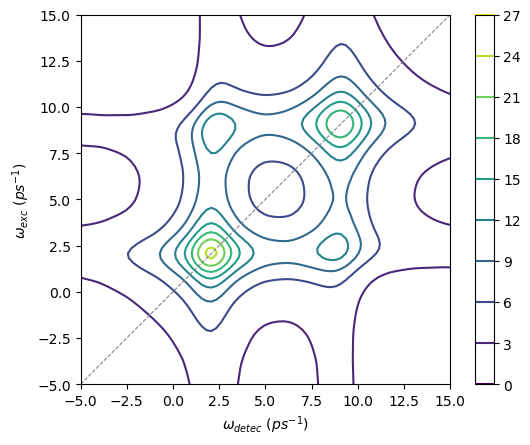

In [14]:
fig, ax =plt.subplots(1,1)
yax = np.flip(Rfs[0].real) + np.flip(Rfs[1].real,1) + np.flip(Rfs[2].real,1) + np.flip(Rfs[3].real) 
cont1=ax.contour(f_time, f_time, yax, levels=8)
cbar = fig.colorbar(cont1)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 15])
ax.set_aspect('equal', adjustable='box')
ax.plot([0, 1], [0, 1], '--', color='gray', transform=ax.transAxes, linewidth=0.75)
ax.set(xlabel = r'$\omega_{detec}\,\, (ps^{-1})$', ylabel = r'$\omega_{exc}\,\,(ps^{-1})$')